# Using NumPy with Rasters

In addition to converting feature classes in to NumPy arrays, we can also convert entire raster datasets into 2-dimensional arrays. This allows us, as we'll see below, to programmatically extract values from these rasters, or we can integrate these arrays with other packages to perform custom analyses with the data. 

For more information on this topic see:
https://4326.us/esri/scipy/devsummit-2016-scipy-arcgis-presentation-handout.pdf

In [1]:
# Import the modules
import arcpy
import numpy as np

In [2]:
#Import a plotting library and enable in-line viewing of plots
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#Set the name of the file we'll import
demFilename = '../Data/DEM.tif'

In [4]:
#Import the DEM as a NumPy array, using only a 200 x 200 pixel subset of it
arrDEM = arcpy.RasterToNumPyArray(demFilename)

#### Exploring our DEM array

In [5]:
#View the raw elevation values
arrDEM

array([[36274, 36349, 36844, ..., 47562, 47958, 48444],
       [36238, 36430, 36964, ..., 48653, 49071, 49646],
       [36207, 36440, 36875, ..., 49691, 50217, 50794],
       ...,
       [30017, 29848, 29730, ..., 25858, 25911, 26204],
       [29753, 29566, 29454, ..., 25616, 25618, 25985],
       [29490, 29329, 29209, ..., 25644, 25202, 25387]])

In [6]:
#What is the shape of the raster (i.e. the # of rows and columns)? 
arrDEM.shape
#...note it's a 2d array

(458, 841)

In [7]:
#Compute stats across the entire DEM
arrDEM.min(), arrDEM.max(),arrDEM.mean()

(22881, 77826, 33670.21201107021)

#### View the values as an image, using the terrain colormap
 * See https://matplotlib.org/tutorials/colors/colormaps.html

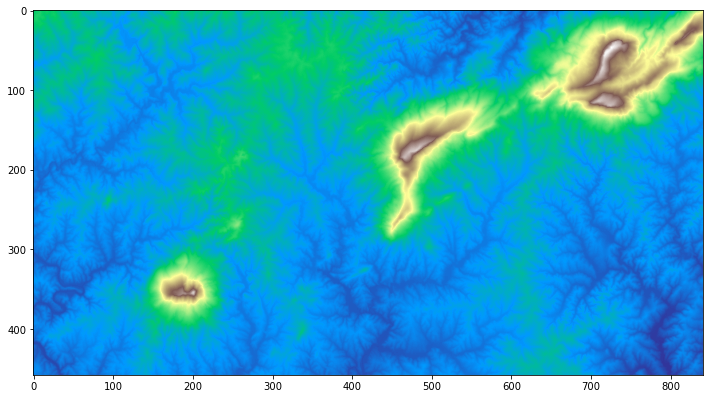

In [8]:
#Create the canvas, setting the size to 12 x 8 units
plt.figure(figsize=(12,8))
#Add the DEM on the canvas, using the terrain colormap 
plt.imshow(arrDEM,cmap='terrain')
#Display the figure in the notebook
plt.show()

### Subsetting the DEM
We can subset by location (image coordinates, or rows and columns) or by value, using binary masks.

* To subset by image coordinates, we can "slice" the data. Here we'll look at just the  northern most 200 rows and columns 600 to 800.

In [9]:
#Extract a subset of the DEM
arrDEMsubset = arrDEM[:200,600:800]

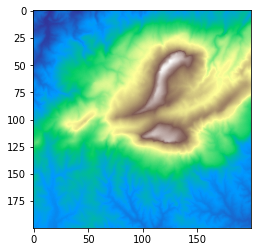

In [10]:
#Display the subset
plt.imshow(arrDEMsubset,cmap='terrain')
plt.show()

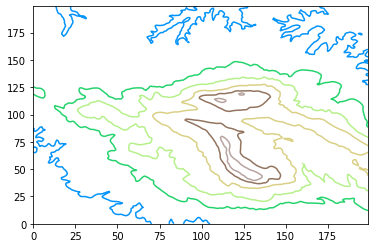

In [11]:
#How about a contour plot!
arrN50 = arrDEM[:200,600:800]
plt.contour(arrDEMsubset,cmap='terrain')
plt.show()

* Or, we can subset by values, i.e. by elevation. Here we'll create a mask of all pixels above 50,000'. The mask generated is the same size as the arrDEM array, but with values of just True (if above 50,000) or False (if not). 

In [12]:
#Create a mask of pixels with elevation < 50000
arrLT50k_mask = arrDEM < 50000
arrLT50k_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

* Since true = 1 and false = 0, to get a count of the pixels meeting our criteria, we just compute the sum. 

In [13]:
#Count the # of pixels above 50000'
arrLT50k_mask.sum()

367481

* And we can map these values

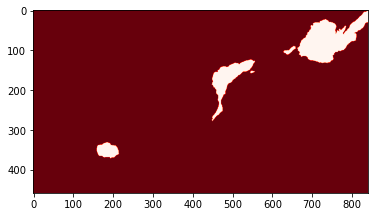

In [16]:
#Show the values
plt.imshow(arrLT50k_mask, cmap='Reds');

* Here is a similar analysis all in one line,revealing pixels between 40k' and 60k'.

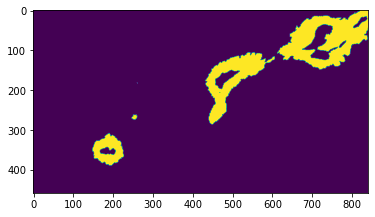

In [15]:
#All in one: Show pixels between 40000' and 60000'
plt.imshow((arrDEM > 40000) & (arrDEM < 60000));

## Stats with numpy
We can compute histograms and other goodies with data in a numpy array.

* First, we'll flatten the 2D array into a 1D series of values

In [17]:
#"Flatten" into a 1D array
arrFlat = arrDEM.flatten()
arrFlat.shape

(385178,)

* NumPy's `histogram` function computes histogram data from our elevations, generating two separate arrays: the first are the cell counts in a bin, and the second lists the elevation values comprising the bin edges. 

In [18]:
histData,bin_edges = np.histogram(arrFlat,bins=20)
bin_edges

array([22881.  , 25628.25, 28375.5 , 31122.75, 33870.  , 36617.25,
       39364.5 , 42111.75, 44859.  , 47606.25, 50353.5 , 53100.75,
       55848.  , 58595.25, 61342.5 , 64089.75, 66837.  , 69584.25,
       72331.5 , 75078.75, 77826.  ])

* Or we can plot the values as a histogram.

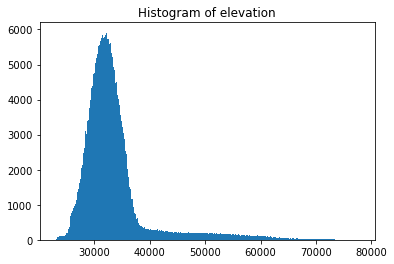

In [19]:
plt.hist(arrFlat,bins='auto')
plt.title("Histogram of elevation")
plt.show()

## More advanced analysis

The SciPy package has a number of multi-dimensional image processing capabilities (see https://docs.scipy.org/doc/scipy/reference/ndimage.html). Here is a somewhat complex example that runs through 10 iterations of computing a neighborhood mean (using the nd.median_filter) with an incrementally growing neighorhood. We then subtract that neighborhood median elevation from the original elevation to compute Topographic Position Index (TPI, see http://www.jennessent.com/downloads/tpi-poster-tnc_18x22.pdf)

If you don't fully understand how it works, at least appreciate that converting a raster to a NumPy array enables us to use other packages to execute custom analyses on the data. 

3 6 9 12 15 18 21 24 27 30 

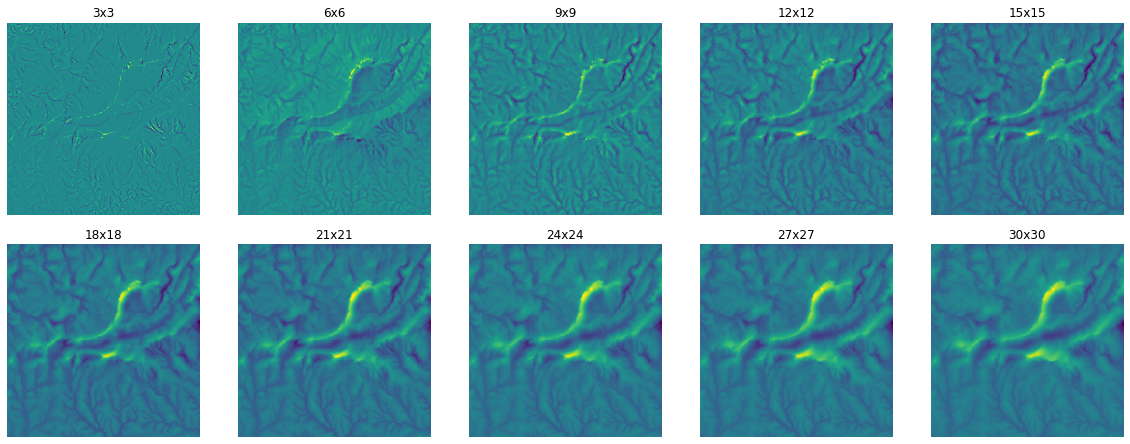

In [20]:
#Import the SciPy and plotting packages
import scipy.ndimage as nd
from matplotlib import pyplot as plt

#Allows plots in our Jupyter Notebook
%matplotlib inline

#Create a 'canvas' onto which we can add plots
fig = plt.figure(figsize=(20,20))

#Loop through 10 iterations
for i in range(10):
    #Create a kernel, intially 3 x 3, then expanding 3 x 3 at each iteration 
    size = (i+1) * 3
    print (size,end=' ')
    #Compute the median value for the kernel surrounding each pixel
    med = nd.median_filter(arrDEMsubset, size)
    #Subtract the median elevation from the original to compute TPI
    tpi = arrDEMsubset - med
    #Create a subplot frame
    a = fig.add_subplot(5, 5,i+1)
    #Show the median interpolated DEM
    plt.imshow(tpi, interpolation='nearest')
    #Set titles for the plot
    a.set_title('{}x{}'.format(size, size))
    plt.axis('off')
    plt.subplots_adjust(hspace = 0.1)
    prev = med

### Recap
By converting a raster dataset to a NumPy array, we enable a wide array of different analyses on our data. 